### Toxic Comments Classification using 1D CNN with Keras

### Import Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.0.0


### Load and Explore Data

In [2]:
# Load data
train_df = pd.read_csv('train.csv').fillna(' ')
train_df.sample(10, random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [3]:
x = train_df['comment_text'].values
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [4]:
# View few toxic comments
train_df.loc[train_df['toxic']==1].sample(10, random_state=10)

,comment_text,toxic
30575,"""\n Are you asking if we would ever block some...",1
36038,Amen my sock-pupinski brother!! Hack-a-long: p...,1
19730,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1
72261,u no wat ass hole go fuck your self and stop b...,1
77923,Go fuck yourself \n\nEat shit and die. 68.0.11...,1
16382,A big thank you\n\nYou have just blocked me in...,1
41247,A message from Jasonceyre \n\n f uc k you ho...,1
69311,"I'm gonna get the ACLU on you, you racist anti...",1
142032,"Hey Freepsbane, does your mother know that you...",1
5613,You guys suk. You really really suck. Fuck you...,1


In [5]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


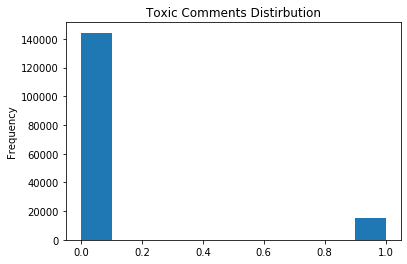

In [7]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind = 'hist', title = 'Toxic Comments Distirbution');

In [8]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Data Prep — Tokenize and Pad Text Data

In [9]:
max_features = 20000
max_text_length = 400

In [10]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen = max_text_length)

### Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [16]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

embedding_dim = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vextors')

Found 13724 word vextors


In [18]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Create the Embedding Layer

In [23]:
model = Sequential()
model.add(Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(
                   embedding_matrix),
                   trainable=False))
model.add(Dropout(0.2))

### Build the Model

In [24]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [27]:
model.add(Conv1D(filters,
                kernel_size,
                padding = 'valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                5,
                padding = 'valid',
                activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         187750    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0

In [28]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train Model

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y,
                                                  test_size = 0.15, random_state = 1)

In [30]:
batch_size = 32
epochs = 3

model.fit(x_train, y_train,
         batch_size = batch_size,
         epochs = 3,
         validation_data = (x_val, y_val))

Train on 135635 samples, validate on 23936 samples
Epoch 1/3
135635/135635 [==============================] - 3699s 27ms/sample - loss: 0.2178 - accuracy: 0.9204 - val_loss: 0.1875 - val_accuracy: 0.9274
Epoch 2/3
135635/135635 [==============================] - 3544s 26ms/sample - loss: 0.1995 - accuracy: 0.9264 - val_loss: 0.1867 - val_accuracy: 0.9288
Epoch 3/3
135635/135635 [==============================] - 3736s 28ms/sample - loss: 0.1936 - accuracy: 0.9282 - val_loss: 0.1920 - val_accuracy: 0.9295


### Evaluate Model

In [31]:
test_df = pd.read_csv('test.csv')

In [32]:
x_test = test_df['comment_text'].values

In [33]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen = max_text_length)

In [34]:
y_testing = model.predict(x_testing, verbose = 1, batch_size = 32)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
y_testing.shape

(153164, 1)

In [36]:
y_testing[0]

array([0.90532464], dtype=float32)

In [37]:
test_df['Toxic'] = ['not toxic' if x < 0.5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(20)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
